# 1. Introduction

In this notebook, we will be investigating the properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features such as color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, We binarized the feature space. the feature_names below to see all 126 binary names.

We will start by running PCA to reduce the dimensionality from 126 down to 2 so that we can easily visualize the data. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. 

Once we've projected the data to 2 dimensions, we'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, we'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

# 2. Imports

## 2.1. Package Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM, GaussianMixture
from matplotlib.colors import LogNorm
from scipy.spatial.distance import cdist

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

%matplotlib inline

## 2.2. Data Imports

In [3]:
# load feature names
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

# load data note that the data is sparse, but there aren't too many features, so we'll use a dense representation
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


# 3. Principal Component Analysis

Here we'll run Principal Components Analysis on the data. The graph below shows what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

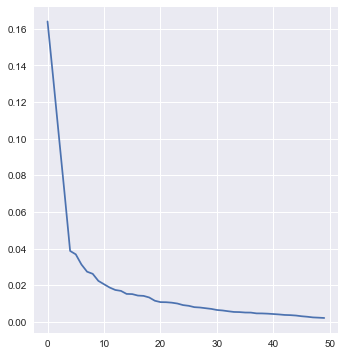

In [5]:
n = 50
pca_model = PCA(n_components = n)
pca_model.fit(train_data)
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(pca_model.explained_variance_ratio_)
plt.show()

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red.

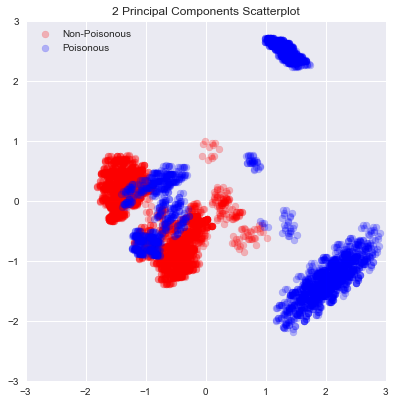

In [6]:
pca_model = PCA(n_components = 2)
train_data_transformed = pca_model.fit_transform(train_data)
    
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0., 0., 1., 1., ])

plt.xlim(-3, 3)
plt.ylim(-3, 3)

cdict = {0:'red', 1:'blue'}
train_label_dict = {0: 'Non-Poisonous', 1: 'Poisonous'}

for i in np.unique(train_labels):

    idx = np.where(train_labels == i)
    ax.scatter(train_data_transformed[:,0][idx],
               train_data_transformed[:,1][idx],
               c=cdict[i],
               label=train_label_dict[i],
               alpha =0.25)
    
plt.title('2 Principal Components Scatterplot')
ax.legend()
plt.show()

# 4. K-Means Clustering

Here we'll run KMeans with [1,16] clusters over the 2d projected data. In the graph below each centroid cluster is marked and a circle is plotted around each one of them to indicate the most distant point assigned to each cluster.

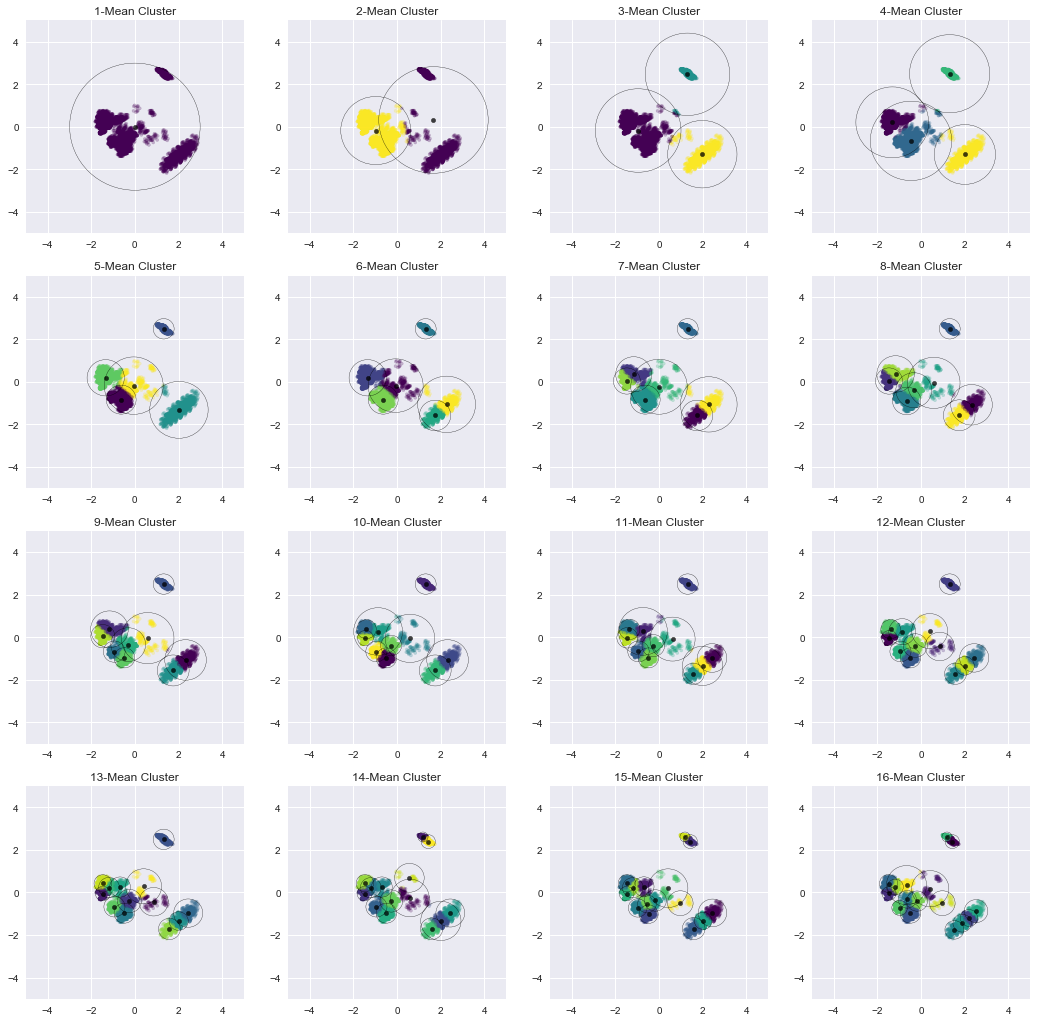

In [7]:
pca_model = PCA(n_components = 2)
train_data_transformed = pca_model.fit_transform(train_data)
    
#empty list for labels and centers
train_cluster_labels = []
train_cluster_centers = []

    
#get labels and centers for k = 1 through k = 16 
for k in range(1,17):

    cluster_model = KMeans(n_clusters=k)
    cluster_model.fit(train_data_transformed)
    train_cluster_labels.append(cluster_model.predict(train_data_transformed))
    train_cluster_centers.append(cluster_model.cluster_centers_)

#initialize a 4x4 plot
figure, ax = plt.subplots(4, 4, figsize=(18, 18))
    
#iterate through the list of labels and centers and plot it on the appropriate axis
cnt = 0
for i in range(4):

    for j in range(4):

        ax[i, j].set_ylim([-5, 5])
        ax[i, j].set_xlim([-5, 5])
        ax[i, j].set_title(str(cnt+1)+'-Mean Cluster')

        #plot the data points along with the predicted labels
        ax[i, j].scatter(train_data_transformed[:, 0],
                         train_data_transformed[:, 1],
                         c=train_cluster_labels[cnt],
                         s=10,
                         cmap='viridis',
                         alpha=0.25)
            
        #overlay the cluster centers on the scatter plot
        ax[i, j].scatter(train_cluster_centers[cnt][:,0],
                         train_cluster_centers[cnt][:,1],
                         c='black',
                         s=20,
                         alpha=0.75)
            
            #overlay cluster circles
        for k in np.unique(train_cluster_labels[cnt]):
            cluster_radius = max([np.linalg.norm(i - train_cluster_centers[cnt][k]) 
                                  for i in zip(train_data_transformed[train_cluster_labels[cnt] == k, 0],
                                               train_data_transformed[train_cluster_labels[cnt] == k, 1])])
            ax[i, j].add_patch(Circle(train_cluster_centers[cnt][k], cluster_radius, edgecolor='black', fill=False))
            
        cnt += 1


# 4. Gaussian Mixture Model

Here we will fit a Gaussian Mixture Model for the positive examples in our 2d projected data. In the graph below we also have the plotted estimated density contours similar to what is shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. In the plot, we vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

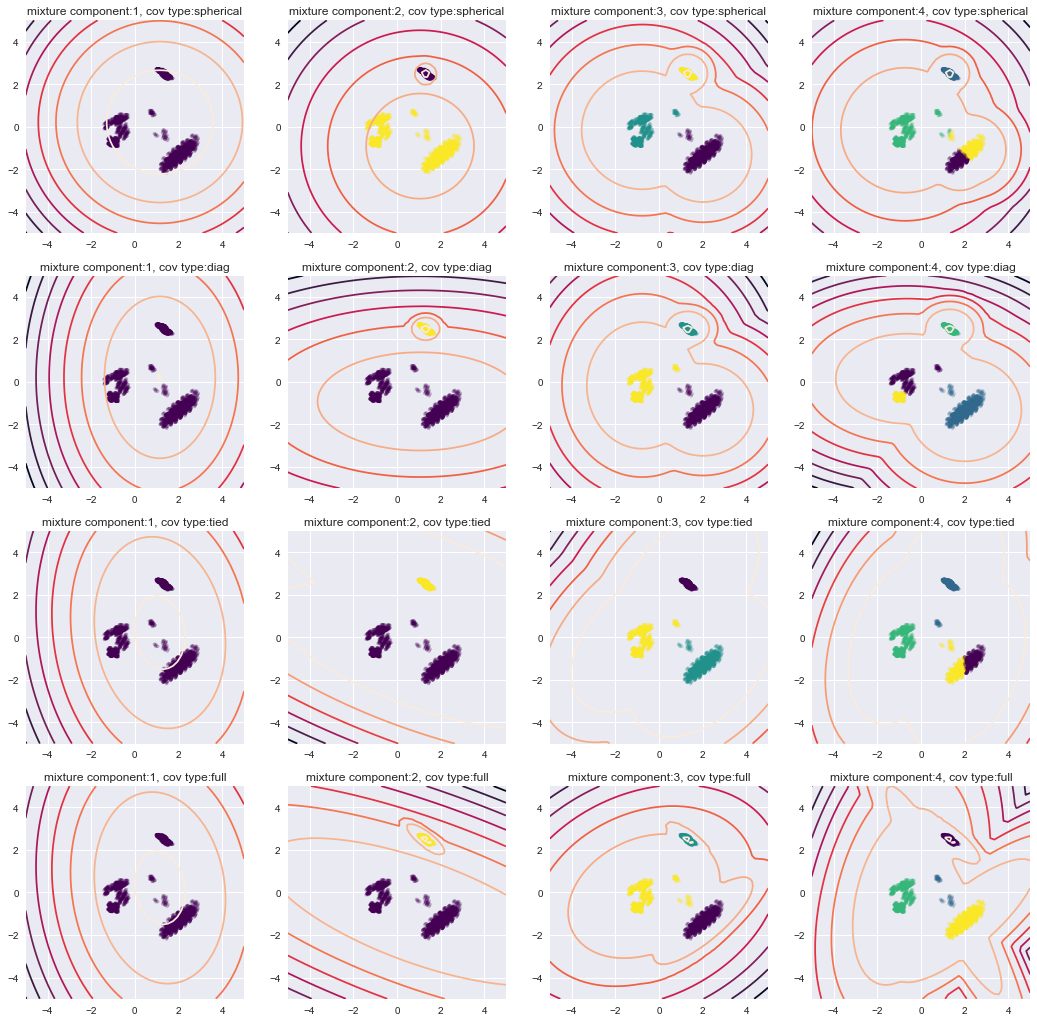

In [8]:
#train pca model
pca_model = PCA(n_components = 2)
train_data_transformed = pca_model.fit_transform(train_data)
    
train_cluster_labels = []
train_score = []
train_data_transformed_pos = train_data_transformed[train_labels == 1].copy()
train_labels_pos = train_labels[train_labels == 1].copy()

X, Y = np.meshgrid(np.linspace(-5, 5), np.linspace(-5,5))
XX = np.array([X.ravel(), Y.ravel()]).T

cov_type = ['spherical', 'diag', 'tied', 'full']

for t in cov_type:
    for n in range(4):
        gm_model = GaussianMixture(n_components=n + 1, covariance_type=t)
        gm_model.fit(train_data_transformed_pos)
        train_cluster_labels.append(gm_model.predict(train_data_transformed_pos))
        Z = gm_model.score_samples(XX)
        Z = Z.reshape(X.shape)
        train_score.append(Z)
    
#initiate figure and axis
figure, ax = plt.subplots(4, 4, figsize=(18, 18))

cnt = 0
for i in range(4):

    for j in range(4):

        ax[i, j].set_ylim([-5, 5])
        ax[i, j].set_xlim([-5, 5])
        ax[i, j].set_title('mixture component:' + str(j + 1) + ', cov type:' + cov_type[i])

        #plot the data points along with the predicted labels
        ax[i, j].scatter(train_data_transformed_pos[:, 0],
                         train_data_transformed_pos[:, 1],
                         c=train_cluster_labels[cnt],
                         s=10,
                         cmap='viridis',
                         alpha=0.25)

        #overlay the contours
        ax[i, j].contour(X, Y, train_score[cnt])

        cnt += 1

# 5. Classification Model

Here we will fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in our 2d projected data. In addition, we will predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score).

In [9]:
pca_model = PCA(n_components=2)
pca_model.fit(train_data)

#transform train and test data using the pca that was fitted against train
train_data_transformed = pca_model.transform(train_data)
test_data_transformed = pca_model.transform(test_data)

train_data_transformed_pos = train_data_transformed[train_labels == 1].copy()
train_labels_pos = train_labels[train_labels == 1].copy()

train_data_transformed_neg = train_data_transformed[train_labels == 0].copy()
train_labels_neg = train_labels[train_labels == 0].copy()
    
#positive label gmm
gm_model_pos = GaussianMixture(n_components=4, covariance_type='full')
gm_model_pos.fit(train_data_transformed_pos)
    
#negative label gmm
gm_model_neg = GaussianMixture(n_components=4, covariance_type='full')
gm_model_neg.fit(train_data_transformed_neg)

predicted_labels = []
    
#loop through each observation, and label based on whcih model has a higher score
for i in range(len(test_labels)):
    score_pos = gm_model_pos.score(test_data_transformed[i].reshape(1,-1))
    score_neg = gm_model_neg.score(test_data_transformed[i].reshape(1,-1))
            
    if score_pos > score_neg:
        pred_label = 1
    else:
        pred_label = 0

    predicted_labels.append(pred_label)

test_accuracy = np.mean(predicted_labels == test_labels)
print('Accuracy:', '{:.4f}'.format(test_accuracy))

Accuracy: 0.9377


Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Here we will run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

In [10]:
def cm_count(row):

    '''function to calculate the covariance matrix count for each type
    '''

    if row['Covariance Type'] == 'full':

        cov_cnt = (((row['PCA Component'] ** 2) - row['PCA Component'])/2) + row['PCA Component']
        return cov_cnt

    elif row['Covariance Type'] == 'tied':

        cov_cnt = (((row['PCA Component'] ** 2) - row['PCA Component'])/2) + row['PCA Component']
        cov_cnt = cov_cnt/row['GMM Component']
        return cov_cnt

    elif row['Covariance Type'] == 'diag':

        cov_cnt = row['PCA Component']
        return cov_cnt

    elif row['Covariance Type'] == 'spherical': 
        cov_cnt = 1
        return cov_cnt

pca_component = []
covariance_type = []
gmm_component = []
accuracy = []

for i in range(10):

    pca_model = PCA(n_components= i + 1)
    pca_model.fit(train_data)

    #transform train and test data using the pca that was fitted against train
    train_data_transformed = pca_model.transform(train_data)
    test_data_transformed = pca_model.transform(test_data)

    train_data_transformed_pos = train_data_transformed[train_labels == 1].copy()
    train_labels_pos = train_labels[train_labels == 1].copy()

    train_data_transformed_neg = train_data_transformed[train_labels == 0].copy()
    train_labels_neg = train_labels[train_labels == 0].copy()

    cov_type = ['spherical', 'diag', 'tied', 'full']

    for t in cov_type:

        for n in range(3):

            #pos label gmm
            gm_model_pos = GaussianMixture(n_components=n + 1, covariance_type=t)
            gm_model_pos.fit(train_data_transformed_pos)


            #pos label gmm
            gm_model_neg = GaussianMixture(n_components= n + 1, covariance_type=t)
            gm_model_neg.fit(train_data_transformed_neg)

            predicted_labels = []

            for lab in range(len(test_labels)):
                score_pos = gm_model_pos.score(test_data_transformed[lab].reshape(1,-1))
                score_neg = gm_model_neg.score(test_data_transformed[lab].reshape(1,-1))

                if score_pos > score_neg:
                    pred_label = 1
                else:
                    pred_label = 0

                predicted_labels.append(pred_label)

        test_accuracy = np.mean(predicted_labels == test_labels)    
        pca_component.append(i + 1)
        covariance_type.append(t)
        gmm_component.append(n + 1)
        accuracy.append(test_accuracy)


#prepare dataframe with all the relevant information
df = pd.DataFrame(data={'PCA Component': pca_component, 
                        'Covariance Type': covariance_type,
                        'GMM Component': gmm_component,
                        'Accuracy': accuracy})

#calculate covariance matrix count
df['Covariance Matrix Count']  = df.apply(cm_count, axis=1)

#calculate the parameter count based on the model's parameters
df['Parameter Count'] = (df['PCA Component'] + df['Covariance Matrix Count']) * df['GMM Component'] * 2

#rearrange columns
df = df[['PCA Component', 'GMM Component', 'Covariance Type', 'Covariance Matrix Count', 'Parameter Count', 'Accuracy']]

#get rid of models where the parameter count is greater than 50
df = df[df['Parameter Count'] <= 50].copy()


#final dataframe sorted by accuracy (highest to lowest)
df = df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
    
return df

,PCA Component,GMM Component,Covariance Type,Covariance Matrix Count,Parameter Count,Accuracy
0,6,3,spherical,1.000000,42.0,0.974199
1,7,3,spherical,1.000000,48.0,0.973310
2,4,3,tied,3.333333,44.0,0.969751
3,5,3,spherical,1.000000,36.0,0.966192
4,2,3,diag,2.000000,24.0,0.947509
5,2,3,spherical,1.000000,18.0,0.945730
6,2,3,tied,1.000000,18.0,0.944840
7,2,3,full,3.000000,30.0,0.930605
8,3,3,tied,2.000000,30.0,0.923488
9,1,3,tied,0.333333,8.0,0.915480
